---
# **LAB 2 - CUDA Programming Model**
---

# ▶️ CUDA tools...

**NVIDIA System Management Interface (nvidia-smi)**

The NVIDIA System Management Interface (**`nvidia-smi`**) is a command line utility, based on top of the NVIDIA Management Library (NVML), intended to aid in the **management** and **monitoring** of NVIDIA GPU devices.

This utility allows administrators to query GPU device state and with the appropriate privileges, permits administrators to modify GPU device state.  It is targeted at the TeslaTM, GRIDTM, QuadroTM and Titan X product, though limited support is also available on other NVIDIA GPUs.

For more details, please refer to the **`nvidia-smi`** documentation ([doc](http://developer.download.nvidia.com/compute/DCGM/docs/nvidia-smi-367.38.pdf))

For information on **Tesla T4** see:

In [ ]:
!nvidia-smi

**Numba code used as a CUDA sanity check**:
-   Imports Numba, a JIT compiler that accelerates Python code.
-	numba.cuda provides GPU (CUDA) support using NVIDIA GPUs.
	- ✔ Confirms NumPy and Numba are installed
	- ✔ Confirms CUDA drivers are visible
	- ✔ Confirms GPU compute capability
	- ✔ Helps debug environment issues before running GPU kernels

Probes the system for available CUDA-capable GPUs. Prints:
-	Number of GPUs
-	GPU names
-	Compute capability
-	Driver/runtime status


In [ ]:
import numpy as np
import numba
from numba import cuda
import warnings
warnings.filterwarnings("ignore")

print(np.__version__)
print(numba.__version__)

cuda.detect()

In [ ]:
# Suppress Numba deprecation and performance warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

In [ ]:
# Check installed versions of numba and llvmlite
!pip list | grep numba 
!pip list | grep llvmlite

# ✅ Blocks and grids

**Grid 1D**: prints DIMs and IDs of grid, block and thread


In [ ]:
from numba import cuda

@cuda.jit
def checkIndex():
    # Absolute position of this thread in the whole grid
    gx = cuda.grid(1)          # 1D global index (equivalent to x in a flattened 1D launch)
    gstride = cuda.gridsize(1) # total number of threads in the whole grid (1D)

    print(  "threadIdx:", cuda.threadIdx.x, cuda.threadIdx.y, cuda.threadIdx.z,
            "| blockIdx:", cuda.blockIdx.x, cuda.blockIdx.y, cuda.blockIdx.z,
            "| blockDim:", cuda.blockDim.x, cuda.blockDim.y, cuda.blockDim.z,
            "| gridDim:",  cuda.gridDim.x,  cuda.gridDim.y,  cuda.gridDim.z)

    print(  "cuda.grid(1) =", gx,
            "| cuda.gridsize(1) =", gstride)

# grid and block definition (1D like dim3 block(4), grid(3))
block = 4
grid = 3

# Print from host
print("Print from host:")
print(f"grid.x = {grid}\t grid.y = 1\t grid.z = 1")
print(f"block.x = {block}\t block.y = 1\t block.z = 1\n")

# Print from device
print("Print from device:")
checkIndex[grid, block]()
cuda.synchronize()



## ↘️ TODO...


Fibonacci ([Fibonacci-wikipedia](https://it.wikipedia.org/wiki/Successione_di_Fibonacci))
$$
\begin{align}
s_0 &= 0,\\
s_1 &= 1,\\
s_{n}&=s_{{n-1}}+s_{{n-2}},\quad \text{(per ogni $n>1$)}
\end{align}
$$


🔹 **Device Helper Functions**

-   You will need two device functions:
    1.  Check if a number is a perfect square
    2.  Check if a number belongs to the Fibonacci sequence
-   Device functions:
    -   run on the GPU
    -   can return values are called from kernels

```{python}
from numba import cuda

@cuda.jit(device=True, inline=True)
def is_perfect_square(m):
    pass

@cuda.jit(device=True, inline=True)
def is_fibonacci(v):
    pass
```

🔹 **Task Description**

-   You must write a CUDA kernel that:
    1.  Computes s using thread and block indices
    2.  Checks whether s is a Fibonacci number
    3.  Write 1 only if s is Fibonacci

-   Kernel that checks and prints results:

```{python}
@cuda.jit
def fibonacci_kernel():
    pass
```

🔹 **Kernel Launch Configuration**

-   Use a 2D block and a 2D grid:

```{python}
block = (8, 6)   # blockDim.x, blockDim.y
grid  = (3, 5)   # gridDim.x, gridDim.y

fibonacci_kernel[grid, block]()
cuda.synchronize()
```

🔹 **Expected Output**

-   Only threads for which s is a Fibonacci number write true
-   Order of prints is not deterministic
-   Output may vary between runs


In [35]:
import numpy as np
from numba import cuda
import math

@cuda.jit(device=True, inline=True)
def is_perfect_square(m):
    if m < 0: return False
    s = int(math.sqrt(m))
    return s**2 == m

@cuda.jit(device=True, inline=True)
def is_fibonacci(v):
    vv = 5*v*v
    return is_perfect_square(vv - 4) or is_perfect_square(vv + 4)

@cuda.jit
def fibonacci_kernel_2D(out):
    x, y = cuda.grid(2)
    #boundary check is needed because we could launch more than the number of thread we need for performance reasons
    if x >= out.shape[0] or y >= out.shape[1]:
        return
    
    # v = x + y
    v = abs(x - y)
    out[x, y] = 1 if is_fibonacci(v) else 0

# ----------------------
#  kernel launch
# ----------------------

n = 200  # matrix size n x n
block = (8, 8)
grid = ( (n + block[0] - 1) // block[0], (n + block[1] - 1) // block[1] )

x = np.zeros((n, n), dtype=np.int32)
d_x = cuda.device_array_like(x)
fibonacci_kernel_2D[grid, block](d_x)

cuda.synchronize()
x = d_x.copy_to_host()
print(x)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


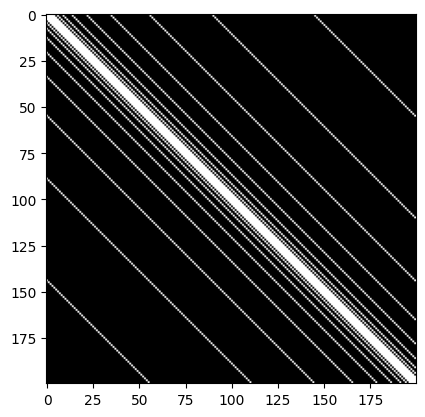

In [36]:
# printing the matrix as an image
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(x, cmap='gray')
#plt.colorbar()
plt.show()

## ➡️ Solution...

In [ ]:
import numpy as np
from numba import cuda
import math
import plotly.graph_objects as go

# --- device helpers ---
@cuda.jit(device=True, inline=True)
def is_perfect_square(m):
    if m < 0:
        return False
    r = int(math.sqrt(m))
    return r * r == m

@cuda.jit(device=True, inline=True)
def is_fibonacci(v):
    if v < 0:
        return False
    vv = np.int64(v)
    t1 = np.int64(5) * vv * vv + np.int64(4)
    t2 = np.int64(5) * vv * vv - np.int64(4)
    return is_perfect_square(t1) or is_perfect_square(t2)

# --- kernel ---
@cuda.jit
def fibonacci_kernel_2D(out):
    x, y = cuda.grid(2)  # 2D global thread indices
    
    # boundary check
    if x >= out.shape[0] or y >= out.shape[1]:
        return
    
    # check Fibonacci
    if is_fibonacci(abs(x-y)):
        out[x, y] = 1


# ----------------------
#  kernel launch
# ----------------------

n = 200  # matrix size n x n

# choose block and grid dimensions
block = (8, 8)   # blockDim.x, blockDim.y
grid  = ((n+block[0]-1) // block[0], (n+block[1]-1) // block[1])   # gridDim.x, gridDim.y

# allocate output array on device
out = np.zeros((n,n), dtype=np.int32)
out_d = cuda.to_device(out)

# launch kernel
fibonacci_kernel_2D[grid, block](out_d)
cuda.synchronize()

# copy result back to host
out_d.copy_to_host(out)

# ----------------------
#  visualize result
# ----------------------
# create heatmap


fig = go.Figure(
    go.Heatmap(
        z=out,
        colorscale="Gray",
        showscale=False
    )
)

fig.update_layout(
    title="Binary Fibonacci Image",
    width=1000,
    height=1000,
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    yaxis_autorange="reversed"
)

fig.show()


# ✅ Image flip 

**Visualizza immagine in python**

In [ ]:
import numpy as np
from PIL import Image

img = Image.open("../images/dog.png")
img_mat = np.array(img).astype(np.uint8)
H, W = img_mat.shape[0], img_mat.shape[1]
print(f"Image size: {W} x {H}")
img


Kernels...

In [ ]:
from numba import cuda


@cuda.jit
def flip_horizontal(img, out):
    """ Flip image horizontally
        
        Params:
        ----------
            img : array_like
                Input image (H, W, 3)
            out : array_like
                Output image (H, W, 3)
    """
    y, x = cuda.grid(2)

    H, W, C = img.shape

    if y < H and x < W:
        if C >= 1:
            out[y, x, 0] = img[y, W - 1 - x, 0]
        if C >= 2:
            out[y, x, 1] = img[y, W - 1 - x, 1]
        if C >= 3:
            out[y, x, 2] = img[y, W - 1 - x, 2]
            
@cuda.jit
def flip_vertical(img, out):
    """ Flip image vertically
        
        Params:
        ----------
            img : array_like
                Input image (H, W, 3)
            out : array_like
                Output image (H, W, 3)
    """
    y, x = cuda.grid(2)
    H, W, C = img.shape
    if y < H and x < W:
        for c in range(C):
            out[y, x, c] = img[H - 1 - y, x, c]

Horizontal flip...

In [ ]:
import time

# Device memory
d_img = cuda.to_device(img_mat)
d_out = cuda.device_array_like(img_mat)

# Launch configuration
threads_per_block = (16, 16)
blocks_per_grid = (
    (H + threads_per_block[0] - 1) // threads_per_block[0],
    (W + threads_per_block[1] - 1) // threads_per_block[1],
)

# Kernel launch
t0 = time.perf_counter()
flip_horizontal[blocks_per_grid, threads_per_block](d_img, d_out)
cuda.synchronize()
t1 = time.perf_counter()
print(f"Kernel time: {(t1 - t0)*1e3:.3f} ms")

# cpu code for verification
tic = time.time()
imgHFlip_cpu = np.flip(img, axis=1)
toc = time.time()
print(f"CPU time: {(toc - tic)*1e3:.3f} ms")

# print speedup 
print(f"Speedup: {(toc - tic)/(t1 - t0):.2f}x")

# Copy back
out = d_out.copy_to_host()
imgHFlip = Image.fromarray(out)
imgHFlip

Vertical flip...

In [ ]:
import time

# Device memory
d_img = cuda.to_device(img_mat)
d_out = cuda.device_array_like(img_mat)
# Launch configuration
threads_per_block = (16, 16)
blocks_per_grid = (
    (H + threads_per_block[0] - 1) // threads_per_block[0],
    (W + threads_per_block[1] - 1) // threads_per_block[1],
)

# Kernel launch
t0 = time.perf_counter()
flip_vertical[blocks_per_grid, threads_per_block](d_img, d_out)
cuda.synchronize()
t1 = time.perf_counter()
print(f"Kernel time: {(t1 - t0)*1e3:.3f} ms")

# cpu code for verification
tic = time.time()
imgVFlip_cpu = np.flip(img, axis=0)
toc = time.time()
print(f"CPU time: {(toc - tic)*1e3:.3f} ms")

# print speedup 
print(f"Speedup: {(toc - tic)/(t1 - t0):.2f}x")

# Copy back
out = d_out.copy_to_host()
imgVFlip = Image.fromarray(out)
imgVFlip

# ✅ Image blurring

## ↘️ TODO...

🔹 **Exercise Tasks**

1. Write a Numba CUDA kernel `blur_box(img, out, mask_size)`
2. Compute `(y, x)` using `cuda.grid(2)`
3. For each output pixel:
   - loop over neighborhood offsets
   - check boundaries
   - accumulate channels
   - divide by `numPixels`
4. Launch with a 2D configuration, e.g. `(16,16)` threads per block
5. Validate correctness vs a CPU implementation on a small image


🔹  **Starter Code (Fill the TODOs)**


```{python}
#| eval: false
import numpy as np
from numba import cuda

@cuda.jit
def blur_box(img, out, mask_size):
    
    # TODO: bounds check

    # TODO: initialize accumulators (float)
    
    # TODO: neighborhood loops
    
    # TODO: write averaged pixel (cast back to dtype)
    
```

In [ ]:
import numpy as np
from PIL import Image

img = Image.open("../images/mandelbrot.png")
img_mat = np.array(img).astype(np.uint8)
H, W = img_mat.shape[0], img_mat.shape[1]
print(f"Image size: {W} x {H}")
img

In [ ]:
from PIL import ImageFilter
import time

# Apply a blur filter to the image
tic = time.time()
blurred_image = img.filter(ImageFilter.BoxBlur(radius=10))
toc = time.time()
print(f"PIL BoxBlur time: {(toc - tic)*1e3:.3f} ms")
# Display the blurred mage
